***Copyright 2020 The TensorFlow Authors.***

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Shape Constraints for Ethics with Tensorflow Lattice

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lattice/tutorials/shape_constraints_for_ethics"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/lattice/blob/master/docs/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/lattice/blob/master/docs/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/lattice/docs/tutorials/shape_constraints_for_ethics.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Overview

This tutorial demonstrates how the TensorFlow Lattice (TFL) library can be used
to train models that behave *responsibly*, and do not violate certain
assumptions that are *ethical* or *fair*. In particular, we will focus on using monotonicity constraints to avoid *unfair penalization* of certain attributes. This tutorial includes demonstrations
of the experiments from the paper
[*Deontological Ethics By Monotonicity Shape Constraints*](https://arxiv.org/abs/2001.11990)
by Serena Wang and Maya Gupta, published at
[AISTATS 2020](https://www.aistats.org/).

We will use TFL premade models on public datasets, but note that
everything in this tutorial can also be done with models constructed from TFL
Keras layers.

Before proceeding, make sure your runtime has all required packages installed
(as imported in the code cells below).

## Setup

Installing TF Lattice package:

In [2]:
#@test {"skip": true}
!pip install -U tensorflow tf-keras tensorflow-lattice seaborn pydot graphviz
!pip install -U tensorflow_decision_forests

  Using cached tensorflow_lattice-2.1.1-py2.py3-none-any.whl.metadata (1.8 kB)


  Using cached graphviz-0.20.3-py3-none-any.whl.metadata (12 kB)


Using cached tensorflow_lattice-2.1.1-py2.py3-none-any.whl (219 kB)
Using cached graphviz-0.20.3-py3-none-any.whl (47 kB)


  Using cached tensorflow_decision_forests-1.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)


  Using cached wurlitzer-3.1.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached ydf-0.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.2 kB)


Using cached tensorflow_decision_forests-1.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (15.9 MB)


Using cached wurlitzer-3.1.1-py3-none-any.whl (8.6 kB)
Using cached ydf-0.9.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (9.5 MB)


Importing required packages:

In [3]:
import tensorflow as tf
import tensorflow_lattice as tfl
import tensorflow_decision_forests as tfdf

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys
import tempfile
logging.disable(sys.maxsize)

2024-12-15 12:24:39.272389: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734265479.296062   73126 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734265479.303333   73126 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Use Keras 2.
version_fn = getattr(tf.keras, "version", None)
if version_fn and version_fn().startswith("3."):
  import tf_keras as keras
else:
  keras = tf.keras

Default values used in this tutorial:

In [5]:
# Default number of training epochs, batch sizes and learning rate.
NUM_EPOCHS = 256
BATCH_SIZE = 256
LEARNING_RATES = 0.01
# Directory containing dataset files.
DATA_DIR = 'https://raw.githubusercontent.com/serenalwang/shape_constraints_for_ethics/master'

# Case study #1: Law school admissions

In the first part of this tutorial, we will consider a case study using the Law
School Admissions dataset from the Law School Admissions Council (LSAC). We will
train a classifier to predict whether or not a student will pass the bar using
two features: the student's LSAT score and undergraduate GPA.

Suppose that the classifier’s score was used to guide law school admissions or
scholarships. According to merit-based social norms, we would expect that
students with higher GPA and higher LSAT score should receive a higher score
from the classifier. However, we will observe that it is easy for models to
violate these intuitive norms, and sometimes penalize people for having a higher
GPA or LSAT score.

To address this *unfair penalization* problem, we can impose monotonicity
constraints so that a model never penalizes higher GPA or higher LSAT score, all
else equal. In this tutorial, we will show how to impose those monotonicity
constraints using TFL.

## Load Law School Data

In [6]:
# Load data file.
law_file_name = 'lsac.csv'
law_file_path = os.path.join(DATA_DIR, law_file_name)
raw_law_df = pd.read_csv(law_file_path, delimiter=',')

Preprocess dataset:

In [7]:
# Define label column name.
LAW_LABEL = 'pass_bar'

In [8]:
def preprocess_law_data(input_df):
  # Drop rows with where the label or features of interest are missing.
  output_df = input_df[~input_df[LAW_LABEL].isna() & ~input_df['ugpa'].isna() &
                       (input_df['ugpa'] > 0) & ~input_df['lsat'].isna()]
  return output_df


law_df = preprocess_law_data(raw_law_df)

### Split data into train/validation/test sets

In [9]:
def split_dataset(input_df, random_state=888):
  """Splits an input dataset into train, val, and test sets."""
  train_df, test_val_df = train_test_split(
      input_df, test_size=0.3, random_state=random_state
  )
  val_df, test_df = train_test_split(
      test_val_df, test_size=0.66, random_state=random_state
  )
  return train_df, val_df, test_df


dataframes = {}
datasets = {}

(dataframes['law_train'], dataframes['law_val'], dataframes['law_test']) = (
    split_dataset(law_df)
)

for df_name, df in dataframes.items():
  datasets[df_name] = tf.data.Dataset.from_tensor_slices(
      ((df[['ugpa']], df[['lsat']]), df[['pass_bar']])
  ).batch(BATCH_SIZE)

2024-12-15 12:24:43.408373: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Visualize data distribution

First we will visualize the distribution of the data. We will plot the GPA and
LSAT scores for all students that passed the bar and also for all students that
did not pass the bar.

In [10]:
def plot_dataset_contour(input_df, title):
  plt.rcParams['font.family'] = ['serif']
  g = sns.jointplot(
      x='ugpa',
      y='lsat',
      data=input_df,
      kind='kde',
      xlim=[1.4, 4],
      ylim=[0, 50])
  g.plot_joint(plt.scatter, c='b', s=10, linewidth=1, marker='+')
  g.ax_joint.collections[0].set_alpha(0)
  g.set_axis_labels('Undergraduate GPA', 'LSAT score', fontsize=14)
  g.fig.suptitle(title, fontsize=14)
  # Adust plot so that the title fits.
  plt.subplots_adjust(top=0.9)
  plt.show()

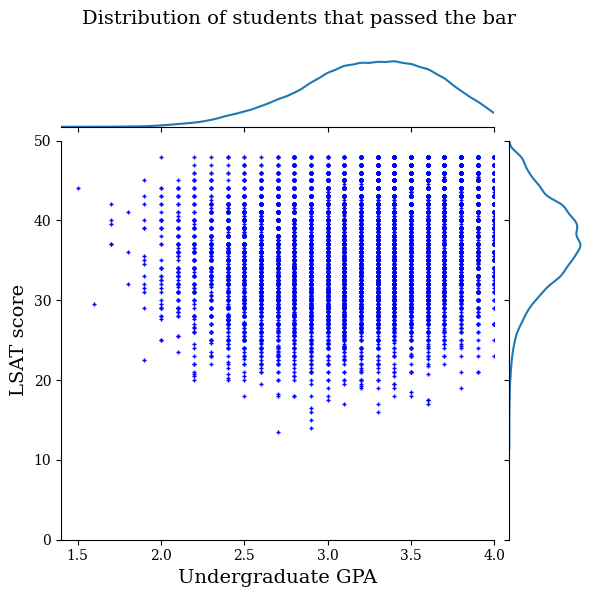

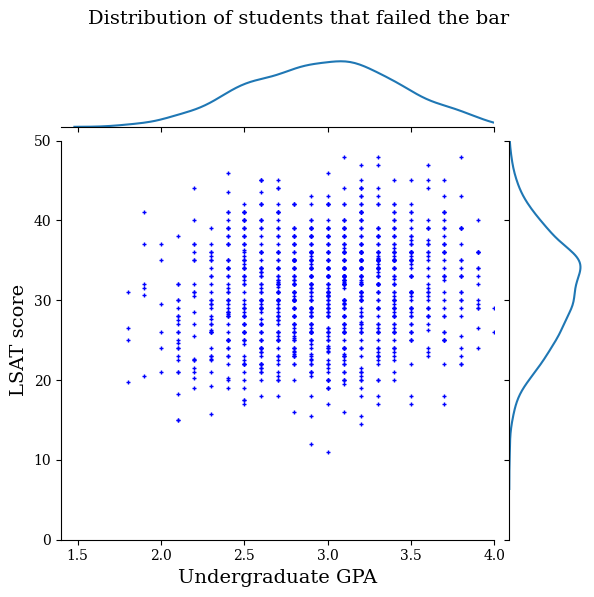

In [11]:
law_df_pos = law_df[law_df[LAW_LABEL] == 1]
plot_dataset_contour(
    law_df_pos, title='Distribution of students that passed the bar')
law_df_neg = law_df[law_df[LAW_LABEL] == 0]
plot_dataset_contour(
    law_df_neg, title='Distribution of students that failed the bar')

## Train calibrated lattice model to predict bar exam passage

Next, we will train a *calibrated lattice model* from TFL to predict whether or
not a student will pass the bar. The two input features will be LSAT score and
undergraduate GPA, and the training label will be whether the student passed the
bar.

We will first train a calibrated lattice model without any constraints. Then, we
will train a calibrated lattice model with monotonicity constraints and observe
the difference in the model output and accuracy.

### Helper functions for visualization of trained model outputs

In [12]:
def plot_model_contour(model, from_logits=False, num_keypoints=20):
  x = np.linspace(min(law_df['ugpa']), max(law_df['ugpa']), num_keypoints)
  y = np.linspace(min(law_df['lsat']), max(law_df['lsat']), num_keypoints)

  x_grid, y_grid = np.meshgrid(x, y)

  positions = np.vstack([x_grid.ravel(), y_grid.ravel()])
  plot_df = pd.DataFrame(positions.T, columns=['ugpa', 'lsat'])
  plot_df[LAW_LABEL] = np.ones(len(plot_df))
  predictions = model.predict((plot_df[['ugpa']], plot_df[['lsat']]))
  if from_logits:
    predictions = tf.math.sigmoid(predictions)
  grid_predictions = np.reshape(predictions, x_grid.shape)

  plt.rcParams['font.family'] = ['serif']
  plt.contour(
      x_grid,
      y_grid,
      grid_predictions,
      colors=('k',),
      levels=np.linspace(0, 1, 11),
  )
  plt.contourf(
      x_grid,
      y_grid,
      grid_predictions,
      cmap=plt.cm.bone,
      levels=np.linspace(0, 1, 11),
  )
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)

  cbar = plt.colorbar()
  cbar.ax.set_ylabel('Model score', fontsize=20)
  cbar.ax.tick_params(labelsize=20)

  plt.xlabel('Undergraduate GPA', fontsize=20)
  plt.ylabel('LSAT score', fontsize=20)

## Train unconstrained (non-monotonic) calibrated lattice model

We create a TFL premade model using a '`CalibratedLatticeConfig`. This model is a calibrated lattice model with an output calibration.

In [13]:
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name='ugpa',
            lattice_size=3,
            pwl_calibration_num_keypoints=16,
            monotonicity=0,
            pwl_calibration_always_monotonic=False,
        ),
        tfl.configs.FeatureConfig(
            name='lsat',
            lattice_size=3,
            pwl_calibration_num_keypoints=16,
            monotonicity=0,
            pwl_calibration_always_monotonic=False,
        ),
    ],
    output_calibration=True,
    output_initialization=np.linspace(-2, 2, num=8),
)

We calculate and populate feature quantiles in the feature configs using the `premade_lib` API.

In [14]:
feature_keypoints = tfl.premade_lib.compute_feature_keypoints(
    feature_configs=model_config.feature_configs,
    features=dataframes['law_train'][['ugpa', 'lsat', 'pass_bar']],
)
tfl.premade_lib.set_feature_keypoints(
    feature_configs=model_config.feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False,
)

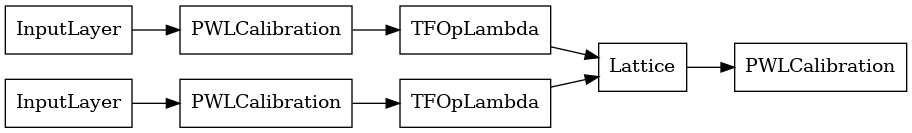

In [15]:
nomon_lattice_model = tfl.premade.CalibratedLattice(model_config=model_config)
keras.utils.plot_model(
    nomon_lattice_model, expand_nested=True, show_layer_names=False, rankdir="LR"
)

In [16]:
nomon_lattice_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
    ],
    optimizer=keras.optimizers.Adam(LEARNING_RATES),
)
nomon_lattice_model.fit(datasets['law_train'], epochs=NUM_EPOCHS, verbose=0)

train_acc = nomon_lattice_model.evaluate(datasets['law_train'])[1]
val_acc = nomon_lattice_model.evaluate(datasets['law_val'])[1]
test_acc = nomon_lattice_model.evaluate(datasets['law_test'])[1]
print(
    'accuracies for train: %f, val: %f, test: %f'
    % (train_acc, val_acc, test_acc)
)

 1/63 [..............................] - ETA: 11s - loss: 0.1992 - accuracy: 0.9336

41/63 [==================>...........] - ETA: 0s - loss: 0.1762 - accuracy: 0.9448 

63/63 [==============================] - 0s 1ms/step - loss: 0.1727 - accuracy: 0.9460


 1/10 [==>...........................] - ETA: 0s - loss: 0.1818 - accuracy: 0.9453

10/10 [==============================] - 0s 1ms/step - loss: 0.1877 - accuracy: 0.9390


 1/18 [>.............................] - ETA: 0s - loss: 0.2045 - accuracy: 0.9258

18/18 [==============================] - 0s 1ms/step - loss: 0.1672 - accuracy: 0.9480


accuracies for train: 0.945995, val: 0.939003, test: 0.948020


 1/13 [=>............................] - ETA: 1s

13/13 [==============================] - 0s 1ms/step


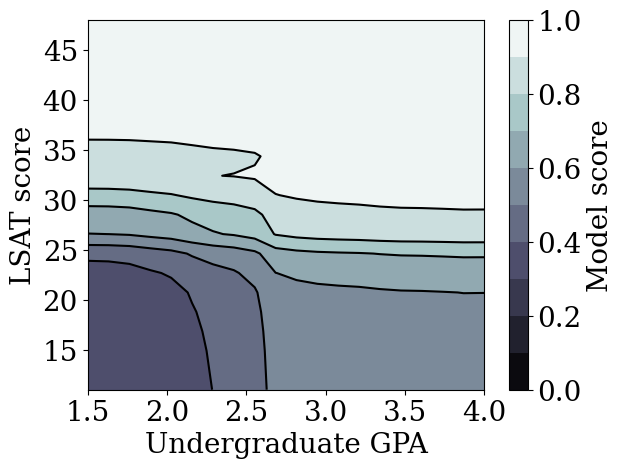

In [17]:
plot_model_contour(nomon_lattice_model, from_logits=True)

## Train monotonic calibrated lattice model

We can get a monotonic model by setting the monotonicity constraints in feature configs.

In [18]:
model_config.feature_configs[0].monotonicity = 1
model_config.feature_configs[1].monotonicity = 1

In [19]:
mon_lattice_model = tfl.premade.CalibratedLattice(model_config=model_config)

mon_lattice_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
    ],
    optimizer=keras.optimizers.Adam(LEARNING_RATES),
)
mon_lattice_model.fit(datasets['law_train'], epochs=NUM_EPOCHS, verbose=0)

train_acc = mon_lattice_model.evaluate(datasets['law_train'])[1]
val_acc = mon_lattice_model.evaluate(datasets['law_val'])[1]
test_acc = mon_lattice_model.evaluate(datasets['law_test'])[1]
print(
    'accuracies for train: %f, val: %f, test: %f'
    % (train_acc, val_acc, test_acc)
)

 1/63 [..............................] - ETA: 9s - loss: 0.1958 - accuracy: 0.9336

40/63 [==================>...........] - ETA: 0s - loss: 0.1763 - accuracy: 0.9446

63/63 [==============================] - 0s 1ms/step - loss: 0.1712 - accuracy: 0.9463


 1/10 [==>...........................] - ETA: 0s - loss: 0.1789 - accuracy: 0.9453

10/10 [==============================] - 0s 1ms/step - loss: 0.1869 - accuracy: 0.9403


 1/18 [>.............................] - ETA: 0s - loss: 0.2047 - accuracy: 0.9258

18/18 [==============================] - 0s 1ms/step - loss: 0.1654 - accuracy: 0.9487


accuracies for train: 0.946308, val: 0.940292, test: 0.948684


 1/13 [=>............................] - ETA: 1s

13/13 [==============================] - 0s 1ms/step


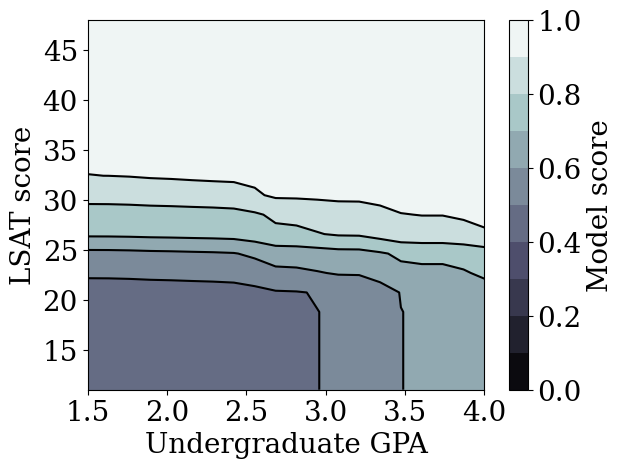

In [20]:
plot_model_contour(mon_lattice_model, from_logits=True)

We demonstrated that TFL calibrated lattice models could be trained to be
monotonic in both LSAT score and GPA without too big of a sacrifice in accuracy.

## Train other unconstrained models

How does the calibrated lattice model compare to other types of models, like
deep neural networks (DNNs) or gradient boosted trees (GBTs)? Do DNNs and GBTs
appear to have reasonably fair outputs? To address this question, we will next
train an unconstrained DNN and GBT. In fact, we will observe that the DNN and
GBT both easily violate monotonicity in LSAT score and undergraduate GPA.

### Train an unconstrained Deep Neural Network (DNN) model

The architecture was previously optimized to achieve high validation accuracy.

In [21]:
keras.utils.set_random_seed(42)
inputs = [
    keras.Input(shape=(1,), dtype=tf.float32),
    keras.Input(shape=(1), dtype=tf.float32),
]
inputs_flat = keras.layers.Concatenate()(inputs)
dense_layers = keras.Sequential(
    [
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation=None),
    ],
    name='dense_layers',
)
dnn_model = keras.Model(inputs=inputs, outputs=dense_layers(inputs_flat))
dnn_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name='accuracy')],
    optimizer=keras.optimizers.Adam(LEARNING_RATES),
)
dnn_model.fit(datasets['law_train'], epochs=NUM_EPOCHS, verbose=0)

train_acc = dnn_model.evaluate(datasets['law_train'])[1]
val_acc = dnn_model.evaluate(datasets['law_val'])[1]
test_acc = dnn_model.evaluate(datasets['law_test'])[1]
print(
    'accuracies for train: %f, val: %f, test: %f'
    % (train_acc, val_acc, test_acc)
)

 1/63 [..............................] - ETA: 6s - loss: 0.1979 - accuracy: 0.9336

44/63 [===================>..........] - ETA: 0s - loss: 0.1754 - accuracy: 0.9472

63/63 [==============================] - 0s 1ms/step - loss: 0.1729 - accuracy: 0.9482


 1/10 [==>...........................] - ETA: 0s - loss: 0.1753 - accuracy: 0.9492

10/10 [==============================] - 0s 1ms/step - loss: 0.1846 - accuracy: 0.9424


 1/18 [>.............................] - ETA: 0s - loss: 0.2040 - accuracy: 0.9336

18/18 [==============================] - 0s 1ms/step - loss: 0.1658 - accuracy: 0.9505


accuracies for train: 0.948248, val: 0.942440, test: 0.950453


 1/13 [=>............................] - ETA: 0s

13/13 [==============================] - 0s 1ms/step


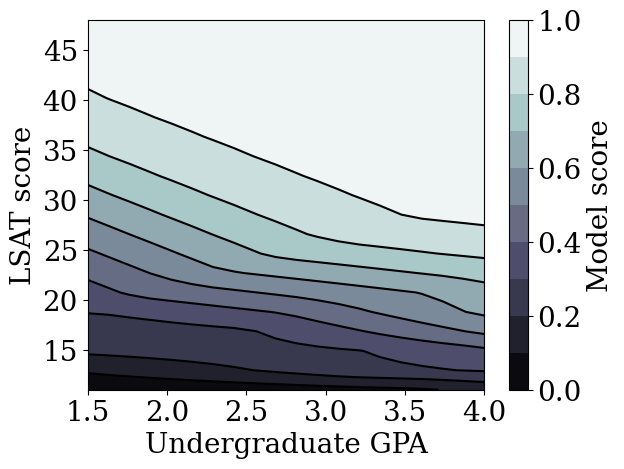

In [22]:
plot_model_contour(dnn_model, from_logits=True)

### Train an unconstrained Gradient Boosted Trees (GBT) model

The tree structure was previously optimized to achieve high validation accuracy.

In [23]:
tree_model = tfdf.keras.GradientBoostedTreesModel(
    exclude_non_specified_features=False,
    num_threads=1,
    num_trees=20,
    max_depth=4,
    growing_strategy='BEST_FIRST_GLOBAL',
    random_seed=42,
    temp_directory=tempfile.mkdtemp(),
)
tree_model.compile(metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])
tree_model.fit(
    datasets['law_train'], validation_data=datasets['law_val'], verbose=0
)

tree_train_acc = tree_model.evaluate(datasets['law_train'], verbose=0)[1]
tree_val_acc = tree_model.evaluate(datasets['law_val'], verbose=0)[1]
tree_test_acc = tree_model.evaluate(datasets['law_test'], verbose=0)[1]
print(
    'accuracies for GBT: train: %f, val: %f, test: %f'
    % (tree_train_acc, tree_val_acc, tree_test_acc)
)

2024-12-15 12:26:19.178391: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2024-12-15 12:26:19.178430: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1850] "goss_beta" set but "sampling_method" not equal to "GOSS".
2024-12-15 12:26:19.178438: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1864] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Num validation examples: tf.Tensor(2328, shape=(), dtype=int32)


I0000 00:00:1734265583.475952   73126 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1734265583.475995   73126 kernel.cc:783] Collect training examples
I0000 00:00:1734265583.476008   73126 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: CATEGORICAL
  categorial {
    min_vocab_frequency: 0
    max_vocab_count: -1
  }
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1734265583.476352   73126 kernel.cc:401] Number of batches: 63
I0000 00:00:1734265583.476369   73126 kernel.cc:402] Number of examples: 15980
I0000 00:00:1734265583.476750   73126 kernel.cc:802] Training dataset:
Number of records: 15980
Number of columns: 3

Number of columns by type:
	NUMERICAL: 2 (66.6667%)
	CATEGORICAL: 1 (33.3333%)

Columns:

NUMERICAL: 2 (66.6667%)
	0: "0" NUMERICAL mean:3.2

accuracies for GBT: train: 0.949625, val: 0.948024, test: 0.951559


 1/13 [=>............................] - ETA: 0s

13/13 [==============================] - 0s 1ms/step


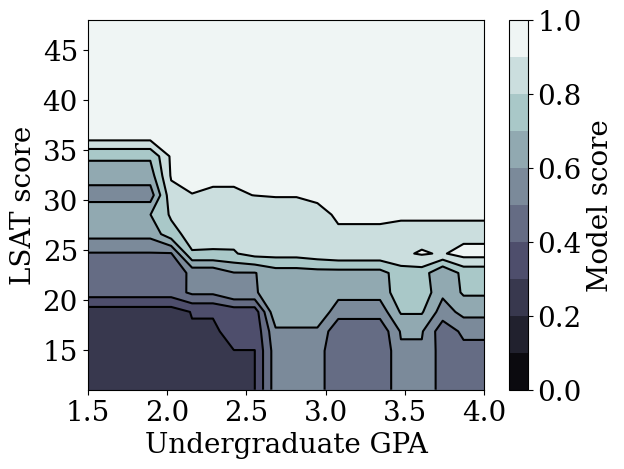

In [24]:
plot_model_contour(tree_model)

# Case study #2: Credit Default

The second case study that we will consider in this tutorial is predicting an
individual's credit default probability. We will use the Default of Credit Card
Clients dataset from the UCI repository. This data was collected from 30,000
Taiwanese credit card users and contains a binary label of whether or not a user
defaulted on a payment in a time window. Features include marital status,
gender, education, and how long a user is behind on payment of their existing
bills, for each of the months of April-September 2005.

As we did with the first case study, we again illustrate using monotonicity
constraints to avoid *unfair penalization*: if the model were to be used to
determine a user’s credit score, it could feel unfair to many if they were
penalized for paying their bills sooner, all else equal. Thus, we apply a
monotonicity constraint that keeps the model from penalizing early payments.

## Load Credit Default data

In [25]:
# Load data file.
credit_file_name = 'credit_default.csv'
credit_file_path = os.path.join(DATA_DIR, credit_file_name)
credit_df = pd.read_csv(credit_file_path, delimiter=',')

In [26]:
# Define label column name.
CREDIT_LABEL = 'default'

### Split data into train/validation/test sets

In [27]:
dfs = {}
datasets = {}

dfs["credit_train"], dfs["credit_val"], dfs["credit_test"] = split_dataset(
    credit_df
)

for df_name, df in dfs.items():
  datasets[df_name] = tf.data.Dataset.from_tensor_slices(
      ((df[['MARRIAGE']], df[['PAY_0']]), df[['default']])
  ).batch(BATCH_SIZE)

### Visualize data distribution

First we will visualize the distribution of the data. We will plot the mean and
standard error of the observed default rate for people with different marital
statuses and repayment statuses. The repayment status represents the number of
months a person is behind on paying back their loan (as of April 2005).

In [28]:
def get_agg_data(df, x_col, y_col, bins=11):
  xbins = pd.cut(df[x_col], bins=bins)
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])
  return data


def plot_2d_means_credit(input_df, x_col, y_col, x_label, y_label):
  plt.rcParams['font.family'] = ['serif']
  _, ax = plt.subplots(nrows=1, ncols=1)
  plt.setp(ax.spines.values(), color='black', linewidth=1)
  ax.tick_params(
      direction='in', length=6, width=1, top=False, right=False, labelsize=18)
  df_single = get_agg_data(input_df[input_df['MARRIAGE'] == 1], x_col, y_col)
  df_married = get_agg_data(input_df[input_df['MARRIAGE'] == 2], x_col, y_col)
  ax.errorbar(
      df_single[(x_col, 'mean')],
      df_single[(y_col, 'mean')],
      xerr=df_single[(x_col, 'sem')],
      yerr=df_single[(y_col, 'sem')],
      color='orange',
      marker='s',
      capsize=3,
      capthick=1,
      label='Single',
      markersize=10,
      linestyle='')
  ax.errorbar(
      df_married[(x_col, 'mean')],
      df_married[(y_col, 'mean')],
      xerr=df_married[(x_col, 'sem')],
      yerr=df_married[(y_col, 'sem')],
      color='b',
      marker='^',
      capsize=3,
      capthick=1,
      label='Married',
      markersize=10,
      linestyle='')
  leg = ax.legend(loc='upper left', fontsize=18, frameon=True, numpoints=1)
  ax.set_xlabel(x_label, fontsize=18)
  ax.set_ylabel(y_label, fontsize=18)
  ax.set_ylim(0, 1.1)
  ax.set_xlim(-2, 8.5)
  ax.patch.set_facecolor('white')
  leg.get_frame().set_edgecolor('black')
  leg.get_frame().set_facecolor('white')
  leg.get_frame().set_linewidth(1)
  plt.show()

/tmpfs/tmp/ipykernel_73126/4037607942.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])
/tmpfs/tmp/ipykernel_73126/4037607942.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])


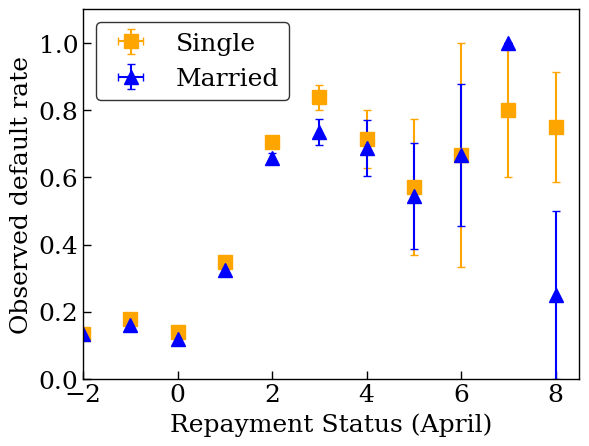

In [29]:
plot_2d_means_credit(
    dfs['credit_train'],
    'PAY_0',
    'default',
    'Repayment Status (April)',
    'Observed default rate',
)

## Train calibrated lattice model to predict credit default rate

Next, we will train a *calibrated lattice model* from TFL to predict whether or
not a person will default on a loan. The two input features will be the person's
marital status and how many months the person is behind on paying back their
loans in April (repayment status). The training label will be whether or not the
person defaulted on a loan.

We will first train a calibrated lattice model without any constraints. Then, we
will train a calibrated lattice model with monotonicity constraints and observe
the difference in the model output and accuracy.

### Helper functions for visualization of trained model outputs

In [30]:
def plot_predictions_credit(
    input_df,
    model,
    x_col,
    x_label='Repayment Status (April)',
    y_label='Predicted default probability',
):
  predictions = model.predict((input_df[['MARRIAGE']], input_df[['PAY_0']]))
  predictions = tf.math.sigmoid(predictions)
  new_df = input_df.copy()
  new_df.loc[:, 'predictions'] = predictions
  plot_2d_means_credit(new_df, x_col, 'predictions', x_label, y_label)

## Train unconstrained (non-monotonic) calibrated lattice model

In [31]:
model_config = tfl.configs.CalibratedLatticeConfig(
    feature_configs=[
        tfl.configs.FeatureConfig(
            name='MARRIAGE',
            lattice_size=3,
            pwl_calibration_num_keypoints=2,
            monotonicity=0,
            pwl_calibration_always_monotonic=False,
        ),
        tfl.configs.FeatureConfig(
            name='PAY_0',
            lattice_size=3,
            pwl_calibration_num_keypoints=16,
            monotonicity=0,
            pwl_calibration_always_monotonic=False,
        ),
    ],
    output_calibration=True,
    output_initialization=np.linspace(-2, 2, num=8),
)

In [32]:
feature_keypoints = tfl.premade_lib.compute_feature_keypoints(
    feature_configs=model_config.feature_configs,
    features=dfs["credit_train"][['MARRIAGE', 'PAY_0', 'default']],
)
tfl.premade_lib.set_feature_keypoints(
    feature_configs=model_config.feature_configs,
    feature_keypoints=feature_keypoints,
    add_missing_feature_configs=False,
)

In [33]:
nomon_lattice_model = tfl.premade.CalibratedLattice(model_config=model_config)

nomon_lattice_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
    ],
    optimizer=keras.optimizers.Adam(LEARNING_RATES),
)
nomon_lattice_model.fit(datasets['credit_train'], epochs=NUM_EPOCHS, verbose=0)

train_acc = nomon_lattice_model.evaluate(datasets['credit_train'])[1]
val_acc = nomon_lattice_model.evaluate(datasets['credit_val'])[1]
test_acc = nomon_lattice_model.evaluate(datasets['credit_test'])[1]
print(
    'accuracies for train: %f, val: %f, test: %f'
    % (train_acc, val_acc, test_acc)
)

 1/83 [..............................] - ETA: 12s - loss: 0.5323 - accuracy: 0.7734

42/83 [==============>...............] - ETA: 0s - loss: 0.4548 - accuracy: 0.8185 

83/83 [==============================] - ETA: 0s - loss: 0.4537 - accuracy: 0.8186

83/83 [==============================] - 0s 1ms/step - loss: 0.4537 - accuracy: 0.8186


 1/12 [=>............................] - ETA: 0s - loss: 0.4454 - accuracy: 0.8281

12/12 [==============================] - 0s 1ms/step - loss: 0.4423 - accuracy: 0.8291


 1/24 [>.............................] - ETA: 0s - loss: 0.4272 - accuracy: 0.8359

24/24 [==============================] - 0s 1ms/step - loss: 0.4547 - accuracy: 0.8168


accuracies for train: 0.818619, val: 0.829085, test: 0.816835


  1/657 [..............................] - ETA: 1:07

 47/657 [=>............................] - ETA: 0s  

 94/657 [===>..........................] - ETA: 0s

144/657 [=====>........................] - ETA: 0s

194/657 [=======>......................] - ETA: 0s

245/657 [==========>...................] - ETA: 0s

296/657 [============>.................] - ETA: 0s

347/657 [==============>...............] - ETA: 0s

398/657 [=================>............] - ETA: 0s

449/657 [===================>..........] - ETA: 0s

500/657 [=====================>........] - ETA: 0s

551/657 [========================>.....] - ETA: 0s

602/657 [==========================>...] - ETA: 0s

653/657 [============================>.] - ETA: 0s

657/657 [==============================] - 1s 1ms/step


/tmpfs/tmp/ipykernel_73126/4037607942.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])
/tmpfs/tmp/ipykernel_73126/4037607942.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])


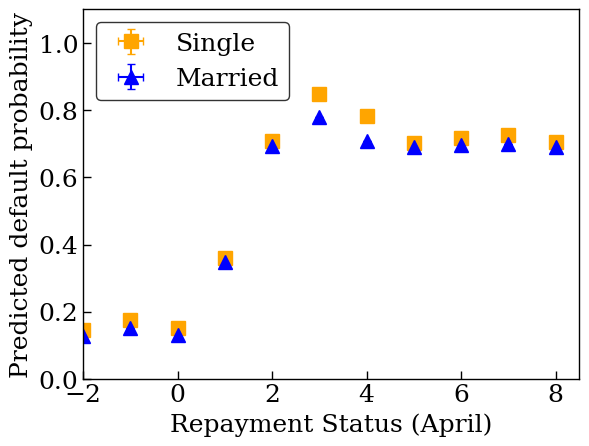

In [34]:
plot_predictions_credit(dfs['credit_train'], nomon_lattice_model, 'PAY_0')

## Train monotonic calibrated lattice model

In [35]:
model_config.feature_configs[0].monotonicity = 1
model_config.feature_configs[1].monotonicity = 1

In [36]:
mon_lattice_model = tfl.premade.CalibratedLattice(model_config=model_config)

mon_lattice_model.compile(
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
    ],
    optimizer=keras.optimizers.Adam(LEARNING_RATES),
)
mon_lattice_model.fit(datasets['credit_train'], epochs=NUM_EPOCHS, verbose=0)

train_acc = mon_lattice_model.evaluate(datasets['credit_train'])[1]
val_acc = mon_lattice_model.evaluate(datasets['credit_val'])[1]
test_acc = mon_lattice_model.evaluate(datasets['credit_test'])[1]
print(
    'accuracies for train: %f, val: %f, test: %f'
    % (train_acc, val_acc, test_acc)
)

 1/83 [..............................] - ETA: 12s - loss: 0.5312 - accuracy: 0.7734

41/83 [=============>................] - ETA: 0s - loss: 0.4553 - accuracy: 0.8190 

82/83 [============================>.] - ETA: 0s - loss: 0.4547 - accuracy: 0.8188

83/83 [==============================] - 0s 1ms/step - loss: 0.4548 - accuracy: 0.8188


 1/12 [=>............................] - ETA: 0s - loss: 0.4451 - accuracy: 0.8320

12/12 [==============================] - 0s 1ms/step - loss: 0.4426 - accuracy: 0.8301


 1/24 [>.............................] - ETA: 0s - loss: 0.4279 - accuracy: 0.8359

24/24 [==============================] - 0s 1ms/step - loss: 0.4551 - accuracy: 0.8172


accuracies for train: 0.818762, val: 0.830065, test: 0.817172


  1/657 [..............................] - ETA: 1:06

 47/657 [=>............................] - ETA: 0s  

 95/657 [===>..........................] - ETA: 0s

145/657 [=====>........................] - ETA: 0s

195/657 [=======>......................] - ETA: 0s

245/657 [==========>...................] - ETA: 0s

295/657 [============>.................] - ETA: 0s

345/657 [==============>...............] - ETA: 0s

395/657 [=================>............] - ETA: 0s

445/657 [===================>..........] - ETA: 0s

495/657 [=====================>........] - ETA: 0s

544/657 [=======================>......] - ETA: 0s

593/657 [==========================>...] - ETA: 0s

643/657 [============================>.] - ETA: 0s

657/657 [==============================] - 1s 1ms/step


/tmpfs/tmp/ipykernel_73126/4037607942.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])
/tmpfs/tmp/ipykernel_73126/4037607942.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data = df[[x_col, y_col]].groupby(xbins).agg(['mean', 'sem'])


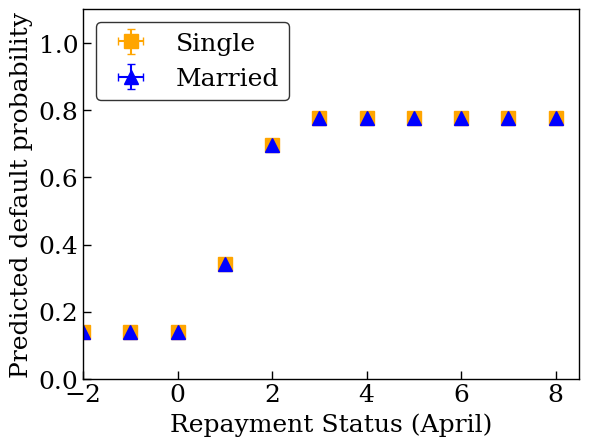

In [37]:
plot_predictions_credit(dfs['credit_train'], mon_lattice_model, 'PAY_0')